In [17]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200725


In [151]:
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
# %matplotlib inline

from urllib.parse import urljoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, KFold, train_test_split
# from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers

IS_COLAB = 'google.colab' in sys.modules

# palabras a buscar en columna descripción
text_mining_keywords = ['cochera', 'sum', 'parrilla', 'pileta']

# url repositorio
github_repo_url = 'https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/'
base_url = github_repo_url if IS_COLAB else ''

## Buscar palabras clave en texto descripción y vectorizar resultados en columnas binarias
def vectorize_descripcion(df: pd.DataFrame):
    descripcion = df['descripcion']
    descripcion[descripcion.isna()] = ''

    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True)  
    vectorizer.fit(text_mining_keywords)

    # hot encoding de los resultados
    df_countvectorizer = vectorizer.transform(descripcion)

    desc = pd.DataFrame(df_countvectorizer.toarray())
    desc.columns = text_mining_keywords
    
    df.drop(['descripcion'], axis=1, inplace=True)
    return(pd.concat([df, desc], axis=1))
    

## Preprocesamiento - Eliminar algunas variables del modelo
def preprocessing(df: pd.DataFrame):
    # guardar los id
    ids = df['id']

    # eliminar columnas innecesarias del modelo
    df.drop(['id', 'pub_inicio', 'pub_fin', 'pub_creada', 'subbarrio', 'titulo'],axis=1, inplace=True)

    df = vectorize_descripcion(df)

    return ids, df


## Partir el set de datos y la variable target
def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df['precio']
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test

## Obtener un subconjunto de los datos de entrenamiento para Grid Search
def get_sample(X: pd.DataFrame, y: pd.DataFrame, sample_size = 0.1):
    size = round(len(X)*sample_size)
    
    idx = np.arange(0, len(X))
    rand_idx = np.random.choice(idx, size, replace=False)
    
    X_sample = X.iloc[rand_idx]
    y_sample = y.iloc[rand_idx]
    return X_sample, y_sample

## Crear pipeline preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_features = ['lat', 'lon', 'habitaciones', 'dormitorios', 'banios',
       'sup_total', 'sup_cubierta', 'cochera', 'sum', 'parrilla',
       'pileta']
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_features = ['barrio']
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features)
    )    

## Crear modelo RandomForestRegressor
def create_train_rfr_model():
    transformer = make_transformer_pipeline()

    pipeline = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(RandomForestRegressor(random_state=5), transformer=StandardScaler()))
    ])
    return pipeline

## Crear modelo SVR
def create_train_svr_model():
    transformer = make_transformer_pipeline()
    
    pipeline = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(SVR(cache_size=1000), transformer=StandardScaler()))
    ])
    return pipeline

## Crear modelo LinearRegression
def create_train_lr_model():
    transformer = make_transformer_pipeline()
    lr = LinearRegression()

    pipeline = make_pipeline(transformer, lr)
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

    return model    

## Crear modelo red neuronal Keras
def build_keras_model(input_dim):
    # crear modelo
    # model = Sequential()
    # model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    # model.add(Dense(1, kernel_initializer='normal'))

    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=input_dim))
    # model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # compilar modelo
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

## Pipeline preprocesamiento para red neuronal
def create_keras_pipeline():
    transformer = make_transformer_pipeline()
    pipeline = Pipeline([
        ('preprocessing', transformer)
    ])
    return pipeline
    
## Graficar predicción vs real
def plot_test_predictions(y_test, y_pred):
    # graficar predicciones contra datos actuales
    plt.figure(figsize = (18,10))
    plot_k = sns.scatterplot(y_test, y_pred)
    plot_k.set(xlabel='Precio test', ylabel='Precio predicción')
    # graficar la identidad
    x_plot = np.linspace(0,np.max(y_test),1000)
    y_plot = x_plot
    plt.plot(x_plot, y_plot, color='r')



In [63]:
df_train = pd.read_excel(urljoin(base_url, 'propiedades_entrenamiento.xlsx'))
df_train.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,titulo,descripcion,precio
0,1,2019-11-20,9999-12-31,2019-11-20,-34.606891,-58.409890,Almagro,NaN,3.0,NaN,2.0,108.0,108.0,PISO EN VENTA 3 AMB C/ ESC. Y DEP. EN ALMAGRO,Piso en Venta 3 ambientes c/ Escritorio y Depe...,150000
1,3,2019-11-19,2020-02-22,2019-11-19,-34.604912,-58.417065,Almagro,NaN,3.0,1.0,2.0,72.0,63.0,Venta Departamento en Almagro Capital Federal ...,"Departamento en Venta, 3 AMBIENTES + COCHERA E...",144000
2,4,2019-05-21,2019-07-03,2019-05-21,-34.600886,-58.431204,Villa Crespo,NaN,3.0,2.0,1.0,57.0,57.0,DEPARTAMENTO EN VENTA,Xintel (GOP-GOP-8943) Venta de Departamento 3 ...,145000
3,5,2019-05-21,2020-05-22,2019-05-21,-34.628760,-58.453224,Flores,NaN,4.0,3.0,3.0,128.0,117.0,DEPARTAMENTO EN VENTA,Xintel (AGU-AGU-3167) Hermoso 3 ambientes al ...,585000
4,6,2019-07-15,2020-02-13,2019-07-15,-34.572144,-58.480173,Villa Urquiza,NaN,3.0,NaN,2.0,NaN,60.0,Departamento en Venta ubicado en Villa Urquiza R,"Venta - Departamento - Argentina, Buenos Aires...",237000


In [64]:
ids, df_train = preprocessing(df_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
X_train, X_test, y_train, y_test = split_data(df_train)

In [66]:
X_train.shape

(48211, 12)

In [67]:
X_test.shape

(2538, 12)

# Prueba con modelo deep learning de Keras

In [68]:
# Preprocesamiento de conjunto entrenamiento
pipe = create_keras_pipeline()
X_train_transformed = pipe.fit_transform(X_train)
X_train_transformed = X_train_transformed.toarray()

In [93]:
# El input shape (= nro de features)
X_train_transformed.shape[1]

69

## Crear modelo y entrenar con early stop

In [ ]:
model = build_keras_model(X_train_transformed.shape[1]) # El input shape es opcional

EPOCHS = 5000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train_transformed, y_train, 
                    epochs=EPOCHS, validation_split = 0.05, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:137169649664.0000,  mae:236177.5312,  mse:137169649664.0000,  val_loss:134397288448.0000,  val_mae:234371.1094,  val_mse:134397288448.0000,  
....................................................................................................
Epoch: 100, loss:122793615360.0000,  mae:218445.0000,  mse:122793615360.0000,  val_loss:120488804352.0000,  val_mae:216473.2031,  val_mse:120488804352.0000,  
....................................................................................................
Epoch: 200, loss:91102208000.0000,  mae:170767.4531,  mse:91102208000.0000,  val_loss:90967130112.0000,  val_mae:168881.5312,  val_mse:90967130112.0000,  
....................................................................................................
Epoch: 300, loss:63120863232.0000,  mae:119414.8359,  mse:63120863232.0000,  val_loss:66215153664.0000,  val_mae:116404.3750,  val_mse:66215153664.0000,  
......................................................................

In [143]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
138,3.272827e+10,70976.718750,3.272827e+10,4.022396e+10,68932.500000,4.022396e+10,138
139,3.269811e+10,70969.976562,3.269811e+10,4.018689e+10,68748.929688,4.018689e+10,139
140,3.268349e+10,70720.242188,3.268349e+10,4.029973e+10,69190.484375,4.029973e+10,140
141,3.268624e+10,70989.007812,3.268624e+10,4.020744e+10,68859.320312,4.020744e+10,141
142,3.267785e+10,70814.960938,3.267785e+10,4.017636e+10,68793.101562,4.017636e+10,142


In [144]:
len(history.history['loss'])

143

In [117]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Precio]')

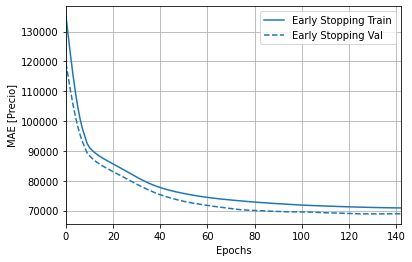

In [145]:
plotter.plot({'Early Stopping': history}, metric = "mae")
plt.ylabel('MAE [Precio]')

Text(0, 0.5, 'MSE [Precio^2]')

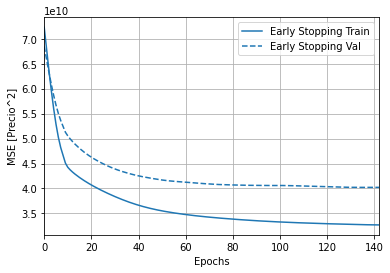

In [146]:
plotter.plot({'Early Stopping': history}, metric = "mse")
plt.ylabel('MSE [Precio^2]')

# Ver como generaliza el modelo en el test set

In [147]:
X_test_transformed = pipe.transform(X_test)
X_test_transformed = X_test_transformed.toarray()
X_test_transformed.shape

(2538, 69)

In [148]:
loss, mae, mse = model.evaluate(X_test_transformed, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Precio".format(mae))
print("Testing set MSE: {:5.2f} Precio".format(mse))

80/80 - 0s - loss: 23930015744.0000 - mae: 67986.2266 - mse: 23930015744.0000
Testing set Mean Abs Error: 67986.23 Precio
Testing set MSE: 23930015744.00 Precio


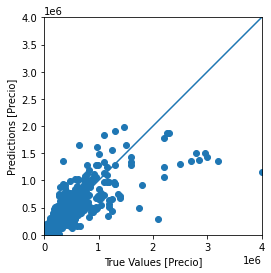

In [140]:
y_test_predictions = model.predict(X_test_transformed).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_predictions)
plt.xlabel('True Values [Precio]')
plt.ylabel('Predictions [Precio]')
lims = [0, 4.e+06]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


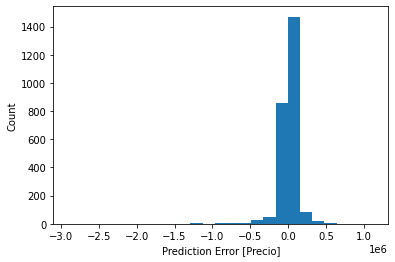

In [123]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Precio]")
_ = plt.ylabel("Count")


# Predecir precios utilizando el modelo entrenado en set de prueba

In [124]:
df_test = pd.read_excel(urljoin(base_url,'propiedades_prueba.xlsx'))
df_test.drop(['precio'], axis=1, inplace=True)
df_test.head()

,id,pub_inicio,pub_fin,pub_creada,lat,lon,barrio,subbarrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,titulo,descripcion
0,2,2019-10-23,9999-12-31,2019-10-23,-34.586330,-58.508957,Villa Devoto,NaN,1.0,NaN,NaN,45,37,Ladines 3200 pb - U$D 124.000 - Departamento ...,Impecable 2 ambientes con patio cubierto con t...
1,34,2019-05-07,2019-06-23,2019-05-07,-34.581699,-58.433547,Palermo,Palermo Hollywood,1.0,1.0,1.0,53,40,VENTA MONOAMBIENTE ESPECTACULAR EN COLEGIALES,Monoambiente impecable divisible a dos ambient...
2,54,2019-10-13,2019-12-23,2019-10-13,-34.628187,-58.429586,Caballito,NaN,2.0,1.0,1.0,42,38,2 ambientes divisibles a estrenar en Palmera C...,Palmera Caballito: Torre con amenities de gran...
3,101,2019-08-25,2019-09-14,2019-08-25,-34.593716,-58.440695,Palermo,NaN,2.0,1.0,1.0,62,38,Depto 2 amb c/terraza prpia Palermo Queens out...,Corredor Responsable: Ariel Champanier - CUCIC...
4,103,2019-10-23,2019-11-09,2019-10-23,-34.591336,-58.447218,Villa Crespo,NaN,2.0,1.0,1.0,44,40,Departamento de dos ambientes con cochera en v...,Departamento de 2 ambientes con cochera ubicad...


In [125]:
ids, df_test = preprocessing(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
df_test.head()

,lat,lon,barrio,habitaciones,dormitorios,banios,sup_total,sup_cubierta,cochera,sum,parrilla,pileta
0,-34.586330,-58.508957,Villa Devoto,1.0,NaN,NaN,45,37,0,0,0,0
1,-34.581699,-58.433547,Palermo,1.0,1.0,1.0,53,40,1,0,0,0
2,-34.628187,-58.429586,Caballito,2.0,1.0,1.0,42,38,0,1,0,0
3,-34.593716,-58.440695,Palermo,2.0,1.0,1.0,62,38,0,0,0,0
4,-34.591336,-58.447218,Villa Crespo,2.0,1.0,1.0,44,40,1,0,0,0


In [127]:
X = pipe.transform(df_test)
X = X.toarray()
X.shape

(2500, 69)

In [128]:
y_pred = model.predict(X).flatten()
y_pred

array([104878.18, 139041.5 , 147478.94, ..., 135393.75, 154343.69,
       114445.84], dtype=float32)

In [129]:
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(y_pred).astype(int) })

In [130]:
data

,id,precio
0,2,104878
1,34,139042
2,54,147479
3,101,149805
4,103,163627
...,...,...
2495,53190,108564
2496,53221,207145
2497,53233,135394
2498,53243,154344


In [131]:
filename = 'propiedades_prediccion.csv'
if IS_COLAB:
  from google.colab import files
  data.to_csv(filename, index=False)
  files.download(filename)
else:
  data.to_csv(filename, index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>